In [1]:
"""
Various helper functions.

Note:
    The functions are in alphabetical order.
"""
import numpy as np


def batch_kron(a: np.ndarray, b: np.ndarray):
    """
    Batch Kronecker product: np.kron(a[i, :, :], b[i, :, :]) for all i.
    """
    return np.einsum('bik,bjl->bijkl', a, b).reshape(a.shape[0], a.shape[1] * b.shape[1], a.shape[2] * b.shape[2])


def cov2cov(matrices: np.ndarray):
    """
    Convert the real representations of complex covariance matrices back to
    complex representations.
    """
    if matrices.ndim == 2:
        # the case of diagonal matrices
        n_mats, n_diag = matrices.shape
        mats = np.zeros([n_mats, n_diag, n_diag])
        for i in range(n_mats):
            mats[i, :, :] = np.diag(matrices[i, :])
    else:
        mats = matrices

    n_mats, rows, columns = mats.shape
    row_half = rows // 2
    column_half = columns // 2
    covs = np.zeros((n_mats, row_half, column_half), dtype=complex)
    for c in range(n_mats):
        upper_left_block = mats[c, :row_half, :column_half]
        upper_right_block = mats[c, :row_half, column_half:]
        lower_left_block = mats[c, row_half:, :column_half]
        lower_right_block = mats[c, row_half:, column_half:]
        covs[c, :, :] = upper_left_block + lower_right_block + 1j * (lower_left_block - upper_right_block)
    return covs


def cplx2real(vec: np.ndarray, axis=0):
    """
    Concatenate real and imaginary parts of vec along axis=axis.
    """
    return np.concatenate([vec.real, vec.imag], axis=axis)


def crandn(*arg, rng=np.random.default_rng()):
    return np.sqrt(0.5) * (rng.standard_normal(arg) + 1j * rng.standard_normal(arg))


# def crandn(*args, rng=None):
#     # Create a TensorFlow random generator with the given seed
#     if rng is None:
#         tf.random.set_seed(1235428719812346)
#         rng = tf.random.Generator.from_seed()
    
#     real_part = tf.sqrt(0.5) * rng.normal(shape=args)
#     imag_part = tf.sqrt(0.5) * rng.normal(shape=args)

#     print('dtype of tf.complex(real_part, imag_part): ', tf.complex(real_part, imag_part).dtype)
    
#     return tf.complex(real_part, imag_part)


def kron_approx_sep_ls(
    mats_A: np.ndarray,
    init_C: np.ndarray,
    rows_B: int,
    cols_B: int,
    iterations: int = 10
):
    """
    Approximate a matrix in terms of a Kronecker product of two matrices. The
    array init_C is an initialization for the matrix C and will be overwritten.
    If it is structured, for example, if it is positive definite, then the
    returned matrices B and C will have the same structure. Section 5 of the
    source explains what kind of structure can be used.

    Note:
        This corresponds to Framework 2 in Section 4 in the source.

    Source:
        "Approximation with Kronecker Products"
        by Van Loan, Pitsianis
        https://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.42.1924&rep=rep1&type=pdf
    """
    if mats_A.ndim == 2:
        mats_A = np.expand_dims(mats_A, 0)
        init_C = np.expand_dims(init_C, 0)

    mats_B = np.zeros((mats_A.shape[0], rows_B, cols_B), dtype=mats_A.dtype)
    mats_C = init_C
    rows_C, cols_C = mats_C.shape[-2:]

    # Extract the blocks A_ij: Split the 3d array of shape (n, rows_B * rows_C, cols_B * cols_C) into a 5d array of
    # shape (n, rows_B, cols_B, rows_C, cols_C) where [:, i, j, :, :] corresponds to the blocks A_ij in equation (2).
    blocks_A = np.zeros((mats_A.shape[0], rows_B, cols_B, rows_C, cols_C), dtype=mats_A.dtype)
    for i, block_row in enumerate(np.split(mats_A, rows_B, axis=-2)):
        for j, block in enumerate(np.split(block_row, cols_B, axis=-1)):
            blocks_A[:, i, j, :, :] = block

    # Extract the blocks Ahat_ij: Split the 3d array of shape (n, rows_B * rows_C, cols_B * cols_C) into a 5d array of
    # shape (n, rows_C, cols_C, rows_B, cols_B) where [:, i, j, :, :] corresponds to the blocks Ahat_ij in equation (4).
    blocks_Ahat = np.zeros((mats_A.shape[0], rows_C, cols_C, rows_B, cols_B), dtype=mats_A.dtype)
    for i in range(rows_C):
        for j in range(cols_C):
            blocks_Ahat[:, i, j, :, :] = \
                mats_A[:, i: i + (rows_B - 1) * rows_C + 1: rows_C, j: j + (cols_B - 1) * cols_C + 1: cols_C]

    beta_or_gamma = np.zeros((mats_A.shape[0], 1, 1), dtype=mats_A.dtype)

    def project(blocks_ij, b_or_c, c_or_b_out):
        """
        For every block A_ij (or Ahat_ij), compute equation (8) (or (9)) in Theorem 4.1.
        """
        np.einsum('ijklm,ilm->ijk', blocks_ij, b_or_c, out=c_or_b_out)
        np.einsum('ijk,ijk->i', b_or_c, b_or_c, out=beta_or_gamma[:, 0, 0])
        c_or_b_out /= beta_or_gamma

    for _ in range(iterations):
        project(blocks_A, mats_C, mats_B)
        project(blocks_Ahat, mats_B, mats_C)

    return mats_B, mats_C


def kron_approx_svd(mats_A: np.ndarray, rows_B: int, cols_B: int, rows_C: int, cols_C: int):
    r"""
    Approximate a matrix in terms of a Kronecker product of two matrices.

    Note:
        Given a matrix A, find matrices B and C of shapes (rows_B, cols_B) and
        (rows_C, cols_C) such that \| A - B \otimes C \|_F is minimized.
        If A is structured, e.g., symmetric or positive definite, the function
        kron_approx_sep_ls can be used.

    Source:
        "Approximation with Kronecker Products"
        by Van Loan, Pitsianis
        https://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.42.1924&rep=rep1&type=pdf
    """
    if mats_A.ndim == 2:
        mats_A = np.expand_dims(mats_A, 0)
    n, rows_A, cols_A = mats_A.shape
    if rows_B * rows_C != rows_A:
        raise ValueError(f'rows_B*rows_C = {rows_A} is required, but rows_B*rows_C = {rows_B*rows_C}')
    if cols_B * cols_C != cols_A:
        raise ValueError(f'cols_B*cols_C = {cols_A} is required, but cols_B*cols_C = {cols_B*cols_C}')

    def block(A, i, j):
        """
        Extract block A_ij from the matrix A. Every block A_ij has shape
        (rows_C, cols_C) and there are rows_B * cols_B such blocks.
        """
        return A[i * rows_C: (i + 1) * rows_C, j * cols_C: (j + 1) * cols_C]

    out_B = np.zeros((n, rows_B, cols_B), dtype=mats_A.dtype)
    out_C = np.zeros((n, rows_C, cols_C), dtype=mats_A.dtype)
    for ni in range(n):
        # the following implements equation (5)
        rearranged_A = np.zeros((rows_B * cols_B, rows_C * cols_C), dtype=mats_A.dtype)
        for j in range(cols_B):
            # extract the matrix A_j
            rearranged_A[j * rows_B: (j + 1) * rows_B, :] = np.concatenate(
                [block(mats_A[ni, :, :], i, j).flatten('F')[np.newaxis, :] for i in range(rows_B)],
                axis=0
            )
        u, s, vh = np.linalg.svd(rearranged_A)
        out_B[ni, :, :] = u[:, 0].reshape(rows_B, cols_B, order='F') * s[0]
        out_C[ni, :, :] = vh[0, :].reshape(rows_C, cols_C, order='F')
    return out_B, out_C


def kron_real(mats1: np.ndarray, mats2: np.ndarray):
    """
    Assuming mats1 and mats2 are real representations of complex covariance
    matrices, compute the real representation of the Kronecker product of the
    complex covariance matrices.
    """
    if mats1.ndim != mats2.ndim:
        raise ValueError(
            'The two arrays need to have the same number of dimensions, '
            f'but we have mats1.ndim = {mats1.ndim} and mats2.ndim = {mats2.ndim}.'
        )
    if mats1.ndim == 2:
        mats1 = np.expand_dims(mats1, 0)
        mats2 = np.expand_dims(mats2, 0)

    n = mats1.shape[0]
    rows1, cols1 = mats1.shape[-2:]
    rows2, cols2 = mats2.shape[-2:]
    row_half1 = rows1 // 2
    column_half1 = cols1 // 2
    row_half2 = rows2 // 2
    column_half2 = cols2 // 2
    rows3 = 2 * row_half1 * row_half2
    cols3 = 2 * column_half1 * column_half2

    out_kron_prod = np.zeros((n, rows3, cols3))
    for i in range(n):
        A1 = mats1[i, :row_half1, :column_half1]
        B1 = mats1[i, :row_half1, column_half1:]
        C1 = mats1[i, row_half1:, :column_half1]
        D1 = mats1[i, row_half1:, column_half1:]

        A2 = mats2[i, :row_half2, :column_half2]
        B2 = mats2[i, :row_half2, column_half2:]
        C2 = mats2[i, row_half2:, :column_half2]
        D2 = mats2[i, row_half2:, column_half2:]

        A = np.kron(A1 + D1, A2 + D2)
        D = -np.kron(C1 - B1, C2 - B2)
        B = -np.kron(A1 + D1, C2 - B2)
        C = np.kron(C1 - B1, A2 + D2)

        A = 0.5 * (A + D)
        D = A
        B = 0.5 * (B - C)
        C = -B

        out_kron_prod[i, :, :] = np.concatenate(
            (np.concatenate((A, B), axis=1), np.concatenate((C, D), axis=1)),
            axis=0
        )
    return np.squeeze(out_kron_prod)


def mat2bsc(mat: np.ndarray):
    """
    Arrange the real and imaginary parts of a complex matrix mat in block-
    skew-circulant form.

    Source:
        See https://ieeexplore.ieee.org/document/7018089.
    """
    upper_half = np.concatenate((mat.real, -mat.imag), axis=-1)
    lower_half = np.concatenate((mat.imag, mat.real), axis=-1)
    return np.concatenate((upper_half, lower_half), axis=-2)


def real2real(mats):
    re = np.real(mats)
    im = np.imag(mats)
    rows = mats.shape[1]
    cols = mats.shape[2]
    out = np.zeros([mats.shape[0], 2*rows, 2*cols])
    out[:, :rows, :cols] = 0.5*re
    out[:, rows:, cols:] = 0.5*re
    return out


def imag2imag(mats):
    im = np.real(mats)
    rows = mats.shape[1]
    cols = mats.shape[2]
    out = np.zeros([mats.shape[0], 2*rows, 2*cols])
    #out[:, :rows, :cols] = 0.5*re
    for i in range(mats.shape[0]):
        out[i, :rows, cols:] = 0.5*im[i,:,:].T
        out[i, rows:, :cols] = 0.5*im[i,:,:]
    #out[:, rows:, cols:] = 0.5*re
    return out


def nmse(actual: np.ndarray, desired: np.ndarray):
    """
    Mean squared error between actual and desired divided by the total number
    of elements.
    """
    mse = 0
    for i in range(actual.shape[0]):
        mse += np.linalg.norm(actual - desired) ** 2 / np.linalg.norm(desired) ** 2
    return mse / actual.shape[0]
    #return np.sum(np.abs(actual - desired) ** 2) / desired.size


def real2cplx(vec: np.ndarray, axis=0):
    """
    Assume vec consists of concatenated real and imaginary parts. Return the
    corresponding complex vector. Split along axis=axis.
    """
    re, im = np.split(vec, 2, axis=axis)
    return re + 1j * im


def sec2hours(seconds: float):
    """"
    Convert a number of seconds to a string h:mm:ss.
    """
    # hours
    h = seconds // 3600
    # remaining seconds
    r = seconds % 3600
    return '{:.0f}:{:02.0f}:{:02.0f}'.format(h, r // 60, r % 60)

def check_random_state(seed):
    import numbers
    """Turn seed into a np.random.RandomState instance

    Parameters
    ----------
    seed : None, int or instance of RandomState
        If seed is None, return the RandomState singleton used by np.random.
        If seed is an int, return a new RandomState instance seeded with seed.
        If seed is already a RandomState instance, return it.
        Otherwise raise ValueError.
    """
    if seed is None or seed is np.random:
        return np.random.mtrand._rand
    if isinstance(seed, numbers.Integral):
        return np.random.RandomState(seed)
    if isinstance(seed, np.random.RandomState):
        return seed
    raise ValueError('%r cannot be used to seed a numpy.random.RandomState'
                     ' instance' % seed)

def print_dict(dict: dict, entries_per_row: int=1):
    """Print the keys and values of dictionary dict."""
    if entries_per_row < 1:
        raise ValueError(f'The number of entries per row needs to be >= 1 but is {entries_per_row}')
    for c, (key, value) in enumerate(dict.items()):
        if c % entries_per_row == 0 and c > 0:
            print()
        else:
            c > 0 and print(' | ', end='')
        print('{}: {}'.format(key, value), end='')
    print()


def dft_matrix(n_antennas, n_grid):
    grid = np.linspace(-1, 1, n_grid + 1)[:n_grid]

    d = 1 / np.sqrt(n_antennas) * np.exp(1j * np.pi * np.outer(np.arange(n_antennas), grid.conj().T))
    return d

#def dist_fac(n_bits: int):
#    """"Compute distortion factor for an arbitrary number of bits."""
#    if n_bits == 1:
#        raise ValueError('The distortion factor for 1-bit is known in closed form.')
#    else:
#        return n_bits * 2**(-2*n_bits)

In [2]:
def scm_channel(
    angles,
    weights,
    n_coherence,
    n_antennas,
    sigma=2.0,
    rng=np.random.default_rng()
):
    (h, t) = chan_from_spectrum(n_coherence, n_antennas, angles, weights, sigma, rng=rng)
    return h, t


def spectrum(u, angles, weights, sigma=2.0):
    u = (u + np.pi) % (2 * np.pi) - np.pi
    theta = np.degrees(np.arcsin(u / np.pi))
    v = _laplace(theta, angles, weights, sigma) \
        + _laplace(180 - theta, angles, weights, sigma)

    return np.degrees(2 * np.pi * v / np.sqrt(np.pi ** 2 - u ** 2))


def _laplace(theta, angles, weights, sigma=2.0):
    # The variance \sigma^2 of a Laplace density is \sigma^2 = 2 * scale_parameter^2.
    # Hence, the standard deviation \sigma is \sigma = sqrt(2) * scale_parameter.
    # The scale_parameter determines the Laplace density.
    # For an angular spread (AS) given in terms of a standard deviation \sigma
    # the scale parameter thus needs to be computed as scale_parameter = \sigma / sqrt(2)
    scale_parameter = sigma / np.sqrt(2)
    x_shifted = np.outer(theta, np.ones(angles.size)) - angles
    x_shifted = (x_shifted + 180) % 360 - 180
    v = weights / (2 * scale_parameter) * np.exp(-np.absolute(x_shifted) / scale_parameter)
    return v.sum(axis=1)

# def spectrum(u, angles, weights, sigma=2.0):
#     pi = tf.constant(np.pi, dtype=tf.float32)
#     u = (u + pi) % (2 * pi) - pi
#     theta = (180.0 / pi) * tf.math.asin(u / pi)
#     v = _laplace(theta, angles, weights, sigma) + _laplace(180 - theta, angles, weights, sigma)

#     return (360.0 / pi) * (2 * pi * v / tf.sqrt(pi**2 - u**2))


# def _laplace(theta, angles, weights, sigma=2.0):
#     # The variance \sigma^2 of a Laplace density is \sigma^2 = 2 * scale_parameter^2.
#     # Hence, the standard deviation \sigma is \sigma = sqrt(2) * scale_parameter.
#     # The scale_parameter determines the Laplace density.
#     # For an angular spread (AS) given in terms of a standard deviation \sigma
#     # the scale parameter thus needs to be computed as scale_parameter = \sigma / sqrt(2)
#     scale_parameter = sigma / tf.sqrt(tf.constant(2.0, dtype=tf.float32))
    
#     theta = tf.matmul(tf.reshape(theta, (theta.shape[0], 1)), tf.reshape(tf.ones_like(angles), (1, angles.shape[0])))

 
#     # Calculate x_shifted using tf.matmul
#     x_shifted = theta - tf.reshape(angles, (1, angles.shape[0]))

#     x_shifted = theta - angles
#     x_shifted = (x_shifted + 180) % 360 - 180
#     print('x_shifted: ', x_shifted.shape)
#     print('scale_parameter: ', scale_parameter.shape)
#     print('weights: ', weights.shape)
#     print('x_shifted: ', tf.exp(-tf.abs(x_shifted) / scale_parameter).shape)
#     v = (weights / (2 * scale_parameter)) * tf.exp(-tf.abs(x_shifted) / scale_parameter)
#     return tf.reduce_sum(v, axis=1)






def chan_from_spectrum(
    n_coherence,
    n_antennas,
    angles,
    weights,
    sigma=2.0,
    rng=np.random.default_rng()
):

    o_f = 100  # oversampling factor (ideally, would use continuous freq. spectrum...)
    n_freq_samples = o_f * n_antennas

    # Sample the spectrum which is defined in equation (78) with epsilon, try
    # to avoid sampling at -pi and pi, thus avoiding dividing by zero.
    epsilon = 1 / 3
    lattice = np.arange(epsilon, n_freq_samples+epsilon) / n_freq_samples * 2 * np.pi - np.pi #sampled between -pi,+pi
    fs = spectrum(lattice, angles, weights, sigma)
    fs = np.reshape(fs, [len(fs), 1])

    # Avoid instabilities due to almost infinite energy at some frequencies
    # (this should only happen at "endfire" of a uniform linear array where --
    # because of the arcsin-transform -- the angular psd grows to infinity).
    almost_inf_threshold = np.max([1, n_freq_samples])  # use n_freq_samples as threshold value...
    almost_inf_freqs = np.absolute(fs) > almost_inf_threshold
    # this should not/only rarely be entered due to the epsilon above; one might even want to increase the threshold
    # to, e.g., 30 * almost_inf_threshold

    # if any(np.absolute(fs) > 20 * almost_inf_threshold):
    #     print("almost inf: ", fs[almost_inf_freqs])

    fs[almost_inf_freqs] = almost_inf_threshold  # * np.exp(1j * np.angle(fs[almost_inf_freqs])) # only real values

    if np.sum(fs) > 0:
        fs = fs / np.sum(fs) * n_freq_samples  # normalize energy

    x = crandn(n_freq_samples, n_coherence, rng=rng)

    h = np.fft.ifft(np.sqrt(fs)*x, axis=0) * np.sqrt(n_freq_samples)
    h = h[0:n_antennas, :]

    # t is the first row of the covariance matrix of h (which is Toeplitz and Hermitian)
    t = np.fft.fft(fs, axis=0) / n_freq_samples
    t = t[0:n_antennas]
    t = np.reshape(t, n_antennas)

    return h.T, t


# def chan_from_spectrum(
#     n_coherence,
#     n_antennas,
#     angles,
#     weights,
#     sigma=2.0,
#     rng=None
# ):
#     # Set random seed for TensorFlow

#     if rng is None:
#         tf.random.set_seed(1235428719812346)
#         rng = tf.random.Generator.from_seed()
        

#     o_f = 100  # oversampling factor (ideally, would use continuous freq. spectrum...)
#     n_freq_samples = o_f * n_antennas

#     # Sample the spectrum using TensorFlow
#     epsilon = 1 / 3
#     lattice = tf.range(epsilon, n_freq_samples + epsilon, dtype=tf.float32) / n_freq_samples * 2 * np.pi - np.pi
#     fs = spectrum(lattice, angles, weights, sigma)  # Assuming you have a spectrum function
    
#     # Reshape fs
#     fs = tf.reshape(fs, [len(fs), 1])

#     # Avoid instabilities due to almost infinite energy at some frequencies
#     almost_inf_threshold = tf.maximum(1.0, tf.cast(n_freq_samples, dtype=tf.float32))
#     almost_inf_freqs = tf.abs(fs) > almost_inf_threshold

#     # Set values for almost infinite frequencies
#     fs = tf.where(almost_inf_freqs, almost_inf_threshold, fs)

#     # Normalize energy
#     fs = fs / tf.reduce_sum(fs) * n_freq_samples

#     # Generate complex random numbers in TensorFlow
#     x = crandn(n_freq_samples, n_coherence, rng=rng)

#     print('dtype of tf.cast(tf.math.sqrt(n_freq_sampöles), dtype=tf.complex64): ', tf.math.sqrt(tf.cast(n_freq_samples, dtype=tf.complex64)).dtype)
#     print('dtype of x: ', x.dtype)
#     print('dtype of multiplication: ', (tf.cast(tf.math.sqrt(fs), dtype=tf.complex64) * x).dtype)

#     # Compute channel response in TensorFlow
#     h = tf.signal.ifft(tf.cast(tf.math.sqrt(fs), dtype=tf.complex64) * x) * tf.math.sqrt(tf.cast(n_freq_samples, dtype=tf.complex64))
#     h = h[0:n_antennas, :]

#     # Compute t as the first row of the covariance matrix of h
#     t = tf.signal.fft(tf.cast(fs, dtype=tf.complex64)) / n_freq_samples
#     t = t[0:n_antennas]
#     t = tf.reshape(t, [n_antennas])

#     return tf.transpose(h), t

In [3]:
class SCMMulti:
    """Class to build a multi path channel model.

    This class defines a multi path channel model.

    Public Methods:

    Instance Variables:

    """

    def __init__(self, path_sigma=2.0, n_path=3):
        """Initialize multi path channel model.

        First, initialise all variables belonging to the multi path channel model.
        """
        self.path_sigma = path_sigma
        self.n_path = n_path

    def generate_channel(
        self,
        n_batches,
        n_coherence,
        n_antennas,
        rng=np.random.default_rng()
    ):
        """Generate multi path model parameters.

        Returns:
            A tuple (h, t) consisting of channels h with
                h.shape = (n_batches, n_coherence, n_antennas)
            and the first rows t of the covariance matrices with
                t.shape = (n_batches, n_antennas)
        """
        h = np.zeros([n_batches, n_coherence, n_antennas], dtype=np.complex64)
        t = np.zeros([n_batches, n_antennas], dtype=np.complex64)

        for i in range(n_batches):
            gains = rng.random(self.n_path)
            gains = gains / np.sum(gains, axis=0)
            angles = (rng.random(self.n_path) - 0.5) * 180

            h[i, :, :], t[i, :] = scm_channel(angles, gains, n_coherence, n_antennas, self.path_sigma, rng=rng)

        return h, t

    # def generate_channel(
    #     self,
    #     n_batches,
    #     n_coherence,
    #     n_antennas,
    #     rng=None
    # ):

    #     if rng is None:
    #         tf.random.set_seed(1235428719812346)
    #         rng = tf.random.Generator.from_seed()
        
    #     # n_batches is a symbolic tensor and i want to convert it to a tf.Tensor with the value of batch_size that i define in the main function
    #     n_batches = tf.convert_to_tensor(n_batches, dtype=tf.int32)

    #     print('n_batches: ', n_batches)

    #     h = tf.zeros([n_batches, n_coherence, n_antennas], dtype=tf.complex64)
    #     t = tf.zeros([n_batches, n_antennas], dtype=tf.complex64)

    #     for i in range(n_batches):
    #         gains = rng.uniform(shape=(self.n_path,))
    #         gains = gains / tf.reduce_sum(gains)
    #         angles = (rng.uniform(shape=(self.n_path,)) - 0.5) * 180.0

    #         # Assuming you have a scm_channel function, replace with your actual implementation
    #         h_i, t_i = scm_channel(angles, gains, n_coherence, n_antennas, self.path_sigma, rng=rng)

    #         print('h_i: ', h_i.shape)
    #         print('h: ', h.shape)
    #         print('t_i: ', t_i.shape)

    #         h = tf.tensor_scatter_nd_add(h, [[i]], h_i)
    #         t = tf.tensor_scatter_nd_add(t, [[i]], t_i)

    #     return h, t

    def get_config(self):
        config = {
            'path_sigma': self.path_sigma,
            'n_path': self.n_path
        }
        return config


In [4]:
from scipy.linalg import toeplitz
def channel_generation(batch_size, n_coherences, n_antennas):
    """
    SIMO version.
    """
    path_sigma = 2.0
    n_path = 1
    channel = SCMMulti(path_sigma=path_sigma, n_path=n_path)

    # generate channel samples with a certain batch size
    rng = np.random.default_rng(1235428719812346)

    h, t = channel.generate_channel(batch_size, n_coherences, n_antennas, rng)
        
    # Initialize an empty array to store the covariance matrices
    C = np.empty((batch_size, n_antennas, n_antennas), dtype=np.complex64)
    
    for i in range(batch_size):
        # Calculate the covariance matrix for each sample
        C[i, :, :] = np.transpose(toeplitz(t[i, :]))
    
    # print('Generated ' + str(batch_size) + ' SIMO channel samples of size ' + str(n_antennas) + 'x1.')
    
    return h, C


# def channel_generation(batch_size, n_coherences, n_antennas, seed=1235428719812346):
#     path_sigma = 2.0
#     n_path = 256
#     # Set random seed for TensorFlow
#     tf.random.set_seed(seed)

#     # Create SCMMulti instance
#     channel = SCMMulti(path_sigma=path_sigma, n_path=n_path)

#     # Generate channel samples with a certain batch size
#     rng = tf.random.Generator.from_seed(seed)
#     h, t = channel.generate_channel(batch_size, n_coherences, n_antennas, rng=rng)

#     # Initialize an empty array to store the covariance matrices
#     C = tf.zeros((batch_size, n_antennas, n_antennas), dtype=tf.complex64)

#     for i in range(batch_size):
#         # Calculate the covariance matrix for each sample
#         t_i = t[i, :]
#         C_i = tf.linalg.toeplitz(t_i)
#         C = tf.tensor_scatter_nd_add(C, [[i]], tf.expand_dims(C_i, axis=0))

#     print('Generated ' + str(batch_size) + ' SIMO channel samples of size ' + str(n_antennas) + 'x1.')

#     return h, C


In [5]:
import tensorflow as tf

class cond_normal_channel(tf.keras.Model):
    def __init__(self):
        super().__init__()
        
    def __call__(self, x, no, batch_size, n_coherence, n_antennas, h=None, C=None):
        if h is None or C is None:
            h, C = channel_generation(batch_size, n_coherence, n_antennas)

        # Noise generation
        real_noise = tf.random.normal(shape=h.shape, mean=0.0, stddev=tf.sqrt(no/2))
        imag_noise = tf.random.normal(shape=h.shape, mean=0.0, stddev=tf.sqrt(no/2))
        complex_noise = tf.complex(real_noise, imag_noise)

        x = tf.reshape(x, [-1, 1, 1])

        y = h * x + complex_noise

        # Uncomment to print first 10 elements of y
        # print('first 10 elements of y: ', y[0,0,:10])

        return y, h, C

2023-11-28 20:35:54.728502: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-11-28 20:35:54.755468: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-28 20:35:54.755496: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-28 20:35:54.755516: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-28 20:35:54.760711: I tensorflow/core/platform/cpu_feature_g

In [6]:
class equalizer(tf.keras.Model):
    def __init__(self):
        super().__init__()

    def __call__(self, h_hat, y, no):
               
        norm_h_hat_squared = tf.reduce_sum(tf.square(tf.abs(h_hat)), axis=-1)
                        
        no_new = tf.math.divide_no_nan(
            no,
            norm_h_hat_squared
        )
                        
        inner_product_h_y = tf.reduce_sum(tf.matmul(y, tf.linalg.adjoint(h_hat)), axis=-1)
                                                
        x_hat = tf.math.divide_no_nan(
            inner_product_h_y,
            tf.cast(norm_h_hat_squared, dtype=tf.complex64)
        )
                        
        return x_hat, no_new


In [7]:
class genie_mmse_estimator(tf.keras.Model):
    def __init__(self):
        super().__init__()
        
    def __call__(self, y, no, C, pilot):
        
        # print('no: ', no)
                                
        # noise_var = no^2 * I. Be careful of the data types!
        noise_var = tf.cast(no * tf.eye(C.shape[-1], batch_shape=[C.shape[0]]), dtype=tf.complex64)
                                        
        # scaled_C = |p|^2 * C
        scaled_C = tf.cast(tf.math.abs(pilot) ** 2, dtype=tf.complex64) * tf.cast(C, dtype=tf.complex64)
                
        eigenvalues, eigenvectors = tf.linalg.eigh(scaled_C)
                        
        # Compute the inverse of (Lambda * noise_var)^-1
        inverse_lambda_noise_var = tf.linalg.inv(tf.linalg.diag(eigenvalues) + noise_var)

        # Compute the inverse of the sum
        inverse = tf.matmul(tf.matmul(eigenvectors, inverse_lambda_noise_var), tf.transpose(eigenvectors, conjugate=True, perm=[0, 2, 1]))
        
        # inverse = tf.linalg.inv(scaled_C + noise_var)
                        
        # scaled_C_2 = conj(p) * C
        scaled_C_2 = tf.math.conj(pilot) * tf.cast(C, dtype=tf.complex64)                        

        # matrix = scaled_C_2 * inverse
        matrix = tf.matmul(scaled_C_2, inverse)

                                                                                                                            
        # h_hat_mmse = (scaled_C_2 * inverse) * y. Be careful of the data types!
        h_hat_mmse = tf.matmul(matrix, tf.transpose(tf.cast(y, dtype=tf.complex64), perm=[0, 2, 1]))   

                                                
        return tf.transpose(h_hat_mmse, perm=[0, 2, 1])

In [8]:
import tensorflow as tf

class ls_estimator(tf.keras.Model):
    def __init__(self):
        super().__init__()

    def __call__(self, y, x):
        h_hat_ls = tf.math.divide_no_nan(y, x)
                
        return h_hat_ls

In [9]:
def check_random_state(seed):
    import numbers
    """Turn seed into a np.random.RandomState instance

    Parameters
    ----------
    seed : None, int or instance of RandomState
        If seed is None, return the RandomState singleton used by np.random.
        If seed is an int, return a new RandomState instance seeded with seed.
        If seed is already a RandomState instance, return it.
        Otherwise raise ValueError.
    """
    if seed is None or seed is np.random:
        return np.random.mtrand._rand
    if isinstance(seed, numbers.Integral):
        return np.random.RandomState(seed)
    if isinstance(seed, np.random.RandomState):
        return seed
    raise ValueError('%r cannot be used to seed a numpy.random.RandomState'
                     ' instance' % seed)


def cplx2real(vec: np.ndarray, axis=0):
    """
    Concatenate real and imaginary parts of vec along axis=axis.
    """
    return np.concatenate([vec.real, vec.imag], axis=axis)


def multivariate_normal_cplx(mean, covariance, n_samples, covariance_type):
    if covariance_type == 'diag':
        cov_sqrt = np.diag(np.sqrt(covariance))
    elif covariance_type == 'spherical':
        cov_sqrt = np.sqrt(covariance) * np.eye(mean.shape[0])
    else:
        cov_sqrt = np.linalg.cholesky(covariance)
    h = np.squeeze(cov_sqrt @ crandn(n_samples, cov_sqrt.shape[0], 1))
    if n_samples > 1:
        h += np.expand_dims(mean, 0)
    return h


def crandn(*arg, rng=np.random.default_rng()):
    return np.sqrt(0.5) * (rng.standard_normal(arg) + 1j * rng.standard_normal(arg))

In [10]:
# Original code from scikit-learn:
# Author: Wei Xue <xuewei4d@gmail.com>
# Modified by Thierry Guillemot <thierry.guillemot.work@gmail.com>
# License: BSD 3 clause

# Extension to the complex-valued case with (block-)Toeplitz and (block-)circulant covariances:
# Author: Benedikt Fesl <benedikt.fesl@tum.de>
# License: BSD 3 clause

import numpy as np
import scipy.stats
from scipy import linalg as scilinalg
from sklearn.mixture import GaussianMixture
from scipy.special import logsumexp
import warnings
from sklearn.exceptions import ConvergenceWarning
from sklearn import cluster


def compute_precision_cholesky(covariances, covariance_type):
    """Compute the Cholesky decomposition of the precisions.

    Parameters
    ----------
    covariances : array-like
        The covariance matrix of the current components.
        The shape depends of the covariance_type.

    covariance_type : {'full', 'tied', 'diag', 'spherical'}
        The type of precision matrices.

    Returns
    -------
    precisions_cholesky : array-like
        The cholesky decomposition of sample precisions of the current
        components. The shape depends of the covariance_type.
    """
    estimate_precision_error_message = (
        "Fitting the mixture model failed because some components have "
        "ill-defined empirical covariance (for instance caused by singleton "
        "or collapsed samples). Try to decrease the number of components, "
        "or increase reg_covar.")

    if covariance_type == 'full':
        n_components, n_features, _ = covariances.shape
        precisions_chol = np.empty((n_components, n_features, n_features), dtype=complex)
        for k, covariance in enumerate(covariances):
            try:
                cov_chol = scilinalg.cholesky(covariance, lower=True)
            except scilinalg.LinAlgError:
                raise ValueError(estimate_precision_error_message)
            precisions_chol[k] = scilinalg.solve_triangular(cov_chol, np.eye(n_features), lower=True).T.conj()
    else:
        if np.any(np.less_equal(covariances, 0.0)):
            raise ValueError(estimate_precision_error_message)
        precisions_chol = 1. / np.sqrt(covariances).conj()
    return precisions_chol


def _compute_log_det_cholesky(matrix_chol, covariance_type, n_features):
    """Compute the log-det of the cholesky decomposition of matrices.
    Parameters
    ----------
    matrix_chol : array-like
        Cholesky decompositions of the matrices.
        'full' : shape of (n_components, n_features, n_features)
        'tied' : shape of (n_features, n_features)
        'diag' : shape of (n_components, n_features)
        'spherical' : shape of (n_components,)
    covariance_type : {'full', 'tied', 'diag', 'spherical'}
    n_features : int
        Number of features.
    Returns
    -------
    log_det_precision_chol : array-like of shape (n_components,)
        The determinant of the precision matrix for each component.
    """
    if covariance_type == "full":
        n_components, _, _ = matrix_chol.shape
        log_det_chol = np.sum(
            np.log(matrix_chol.reshape(n_components, -1)[:, :: n_features + 1]), 1
        )
    elif covariance_type == "diag":
        log_det_chol = np.sum(np.log(matrix_chol), axis=1)
    else:
        log_det_chol = n_features * (np.log(matrix_chol))
    return log_det_chol



class GaussianMixtureCplx:
    def __init__(self, *gmm_args, **gmm_kwargs):
        self.gm = GaussianMixture(*gmm_args, **gmm_kwargs)
        self.means_cplx = None
        self.covs_cplx = None
        self.chol = None
        self.params = dict()
        self.F2 = None

    def __repr__(self):
        return self.gm.__repr__()

    def __str__(self):
        return self.gm.__str__()

    @property
    def covariances(self):
        return self.gm.covariances_.copy()

    @property
    def converged(self):
        return self.gm.converged_

    @property
    def means(self):
        return self.gm.means_.copy()

    @property
    def precisions(self):
        return np.einsum('ijk,ilk->ijl', self.gm.precisions_cholesky_, self.gm.precisions_cholesky_.conj())

    @property
    def precisions_cholesky(self):
        return self.gm.precisions_cholesky_.copy()

    @property
    def weights(self):
        return self.gm.weights_.copy()

    def fit(self, h, blocks=None, zero_mean=False):
        """
        Fit an sklearn Gaussian mixture model using complex data h.
        """
        if zero_mean:
            self.params['zero_mean'] = True
        else:
            self.params['zero_mean'] = False
        self.params['cov_type'] = self.gm.covariance_type
        self.params['dft_trafo'] = False # indicate whether parameters are given in Fourier domain

        if self.gm.covariance_type == 'full' or self.gm.covariance_type == 'diag' or self.gm.covariance_type \
                == 'spherical' :
            self.fit_cplx(h)
            self.means_cplx = self.gm.means_.copy()
            self.covs_cplx = self.gm.covariances_.copy()
            self.chol = self.gm.precisions_cholesky_.copy()
        elif self.gm.covariance_type == 'circulant':
            dft_matrix = np.fft.fft(np.eye(h.shape[-1], dtype=complex)) / np.sqrt(h.shape[-1])
            self.gm.covariance_type = 'diag'
            self.fit_cplx(np.fft.fft(h, axis=1) / np.sqrt(h.shape[-1]))
            self.means_cplx = self.gm.means_ @ dft_matrix.conj()
            self.gm._means = self.means_cplx.copy()
            self.covs_cplx = np.zeros([self.means_cplx.shape[0], self.means_cplx.shape[-1],
                                       self.means_cplx.shape[-1]], dtype=complex)
            for i in range(self.means_cplx.shape[0]):
                self.covs_cplx[i] = dft_matrix.conj().T @ np.diag(self.gm.covariances_[i]) @ dft_matrix
            self.gm.covariances_ = self.covs_cplx.copy()
            self.chol = compute_precision_cholesky(self.covs_cplx, 'full')
            self.gm.precisions_cholesky_ = self.chol.copy()
            self.gm.covariance_type = 'full'
        elif self.gm.covariance_type == 'block-circulant':
            self.gm.covariance_type = 'diag'
            n_1, n_2 = blocks
            F1 = np.fft.fft(np.eye(n_1)) / np.sqrt(n_1)
            F2 = np.fft.fft(np.eye(n_2)) / np.sqrt(n_2)
            dft_matrix = np.kron(F1, F2)
            self.F2 = dft_matrix
            self.fit_cplx(np.squeeze(dft_matrix @ np.expand_dims(h, 2)))
            self.means_cplx = self.gm.means_ @ dft_matrix.conj()
            self.gm._means = self.means_cplx.copy()
            self.covs_cplx = np.zeros([self.means_cplx.shape[0], self.means_cplx.shape[-1],
                                       self.means_cplx.shape[-1]], dtype=complex)
            for i in range(self.means_cplx.shape[0]):
                self.covs_cplx[i] = dft_matrix.conj().T @ np.diag(self.gm.covariances_[i]) @ dft_matrix
            self.gm.covariances_ = self.covs_cplx.copy()
            self.chol = compute_precision_cholesky(self.covs_cplx, 'full')
            self.gm.precisions_cholesky_ = self.chol.copy()
            self.gm.covariance_type = 'full'
            self.gm.means_ = self.means_cplx
            self.gm.precisions_cholesky_ = self.chol
        elif self.gm.covariance_type == 'toeplitz':
            self.params['inv-em'] = True
            self.gm.covariance_type = 'full'
            n_1 = h.shape[1]
            self.F2 = np.fft.fft(np.eye(2 * n_1))[:, :n_1] / np.sqrt(2 * n_1)
            self.fit_cplx(h)
            self.means_cplx = self.gm.means_.copy()
            self.covs_cplx = self.gm.covariances_.copy()
            self.chol = self.gm.precisions_cholesky_.copy()
        elif self.gm.covariance_type == 'block-toeplitz':
            self.params['inv-em'] = True
            self.gm.covariance_type = 'full'
            n_1, n_2 = blocks
            F2_1 = np.fft.fft(np.eye(2 * n_1))[:, :n_1] / np.sqrt(2 * n_1)
            F2_2 = np.fft.fft(np.eye(2 * n_2))[:, :n_2] / np.sqrt(2 * n_2)
            self.F2 = np.kron(F2_1, F2_2)
            self.fit_cplx(h)
            self.means_cplx = self.gm.means_.copy()
            self.covs_cplx = self.gm.covariances_.copy()
            self.chol = self.gm.precisions_cholesky_.copy()
        else:
            raise NotImplementedError(f'Fitting for covariance_type = {self.gm.covariance_type} is not implemented.')

    def sample(self, n_samples=1):
        """Generate random samples from the fitted Gaussian distribution.
        Parameters
        ----------
        n_samples : int, default=1
            Number of samples to generate.
        Returns
        -------
        X : array, shape (n_samples, n_features)
            Randomly generated sample.
        y : array, shape (nsamples,)
            Component labels.
        """

        if n_samples < 1:
            raise ValueError(
                "Invalid value for 'n_samples': %d . The sampling requires at "
                "least one sample." % (self.gm.n_components)
            )

        _, n_features = self.means_cplx.shape
        rng = check_random_state(self.gm.random_state)
        n_samples_comp = rng.multinomial(n_samples, self.gm.weights_)

        X = np.vstack(
            [
                #rng.multivariate_normal(mean, covariance, int(sample))
                multivariate_normal_cplx(mean, covariances, int(sample), self.gm.covariance_type)
                for (mean, covariances, sample) in zip(
                    self.means_cplx, self.covs_cplx, n_samples_comp
                )
            ]
        )


        y = np.concatenate(
            [np.full(sample, j, dtype=int) for j, sample in enumerate(n_samples_comp)]
        )

        return (X, y)

    def predict_cplx(self, X):
        """Predict the labels for the data samples in X using trained model.

                Parameters
                ----------
                X : array-like of shape (n_samples, n_features)
                    List of n_features-dimensional data points. Each row
                    corresponds to a single data point.

                Returns
                -------
                labels : array, shape (n_samples,)
                    Component labels.
                """
        return self._estimate_weighted_log_prob(X).argmax(axis=1)

    def predict_proba_cplx(self, X):
        """Predict posterior probability of each component given the data.

        Parameters
        ----------
        X : array-like of shape (n_samples, n_features)
            List of n_features-dimensional data points. Each row
            corresponds to a single data point.

        Returns
        -------
        resp : array, shape (n_samples, n_components)
            Returns the probability each Gaussian (state) in
            the model given each sample.
        """
        _, log_resp = self._estimate_log_prob_resp(X)
        return np.exp(log_resp)

    def _estimate_weighted_log_prob(self, X):
        """Estimate the weighted log-probabilities, log P(X | Z) + log weights.

        Parameters
        ----------
        X : array-like of shape (n_samples, n_features)

        Returns
        -------
        weighted_log_prob : array, shape (n_samples, n_component)
        """
        return self._estimate_log_prob(X) + self._estimate_log_weights()

    def _estimate_log_weights(self):
        return np.log(self.gm.weights_)

    def _estimate_log_prob(self, X):
        return self._estimate_log_gaussian_prob(X, self.gm.means_, self.gm.precisions_cholesky_,  self.gm.covariance_type)

    def _estimate_log_gaussian_prob(self, X, means, precisions_chol, covariance_type):
        """Estimate the log Gaussian probability.
        Parameters
        ----------
        X : array-like of shape (n_samples, n_features)
        means : array-like of shape (n_components, n_features)
        precisions_chol : array-like
            Cholesky decompositions of the precision matrices.
            'full' : shape of (n_components, n_features, n_features)
            'diag' : shape of (n_components, n_features)
            'spherical' : shape of (n_components,)
        covariance_type : {'full', 'tied', 'diag', 'spherical'}
        Returns
        -------
        log_prob : array, shape (n_samples, n_components)
        """
        n_samples, n_features = X.shape
        n_components, _ = means.shape
        # The determinant of the precision matrix from the Cholesky decomposition
        # corresponds to the negative half of the determinant of the full precision
        # matrix.
        # In short: det(precision_chol) = - det(precision) / 2
        log_det = np.real(_compute_log_det_cholesky(precisions_chol, covariance_type, n_features))

        if covariance_type == "full":
            log_prob = np.empty((n_samples, n_components))
            for k, (mu, prec_chol) in enumerate(zip(means, precisions_chol)):
                y = np.dot(X, prec_chol.conj()) - np.dot(mu, prec_chol.conj())
                log_prob[:, k] = np.sum(np.abs(y)**2, axis=1)

        elif covariance_type == "diag":
            precisions = np.abs(precisions_chol) ** 2
            log_prob = (
                    np.sum((np.abs(means) ** 2 * precisions), 1)
                    - 2.0 * np.real(np.dot(X, (means.conj() * precisions).T))
                    + np.dot(np.abs(X) ** 2, precisions.T)
            )
        elif covariance_type == "spherical":
            precisions = np.abs(precisions_chol) ** 2
            log_prob = (
                    np.sum(np.abs(means) ** 2, 1) * precisions
                    - 2 * np.real(np.dot(X, means.conj().T) * precisions)
                    + np.outer((X.conj() * X).sum(axis=1), precisions)
            )
        # Since we are using the precision of the Cholesky decomposition,
        # `- log_det_precision` becomes `+ 2 * log_det_precision_chol`
        return -(n_features * np.log(np.pi) + np.real(log_prob)) + 2*log_det

    def fit_cplx(self, X, y=None):
        """Estimate model parameters with the EM algorithm.

        The method fits the model ``n_init`` times and sets the parameters with
        which the model has the largest likelihood or lower bound. Within each
        trial, the method iterates between E-step and M-step for ``max_iter``
        times until the change of likelihood or lower bound is less than
        ``tol``, otherwise, a ``ConvergenceWarning`` is raised.
        If ``warm_start`` is ``True``, then ``n_init`` is ignored and a single
        initialization is performed upon the first call. Upon consecutive
        calls, training starts where it left off.

        Parameters
        ----------
        X : array-like of shape (n_samples, n_features)
            List of n_features-dimensional data points. Each row
            corresponds to a single data point.

        Returns
        -------
        self
        """
        self.fit_predict(X, y)
        return self

    def fit_predict(self, X, y=None):
        """Estimate model parameters using X and predict the labels for X.

        The method fits the model n_init times and sets the parameters with
        which the model has the largest likelihood or lower bound. Within each
        trial, the method iterates between E-step and M-step for `max_iter`
        times until the change of likelihood or lower bound is less than
        `tol`, otherwise, a :class:`~sklearn.exceptions.ConvergenceWarning` is
        raised. After fitting, it predicts the most probable label for the
        input data points.

        .. versionadded:: 0.20

        Parameters
        ----------
        X : array-like of shape (n_samples, n_features)
            List of n_features-dimensional data points. Each row
            corresponds to a single data point.

        Returns
        -------
        labels : array, shape (n_samples,)
            Component labels.
        """
        # X = _check_X(X, self.n_components, ensure_min_samples=2)
        self.gm._check_n_features(X, reset=True)
        self.gm._check_parameters(X)

        # self.gm._validate_params()

        if X.shape[0] < self.gm.n_components:
            raise ValueError(
                "Expected n_samples >= n_components "
                f"but got n_components = {self.gm.n_components}, "
                f"n_samples = {X.shape[0]}"
            )

        # if we enable warm_start, we will have a unique initialisation
        do_init = not(self.gm.warm_start and hasattr(self, 'converged_'))
        n_init = self.gm.n_init if do_init else 1

        max_lower_bound = -np.infty
        self.gm.converged_ = False

        random_state = check_random_state(self.gm.random_state)

        n_samples, _ = X.shape
        for init in range(n_init):
            self.gm._print_verbose_msg_init_beg(init)

            if do_init:
                self._initialize_parameters(X, random_state)

            lower_bound = (-np.infty if do_init else self.gm.lower_bound_)

            for n_iter in range(1, self.gm.max_iter + 1):
                prev_lower_bound = lower_bound

                log_prob_norm, log_resp = self._e_step(X)
                self._m_step(X, log_resp)
                lower_bound = self.gm._compute_lower_bound(
                    log_resp, log_prob_norm)

                change = lower_bound - prev_lower_bound
                self.gm._print_verbose_msg_iter_end(n_iter, change)

                if abs(change) < self.gm.tol:
                    self.gm.converged_ = True
                    break

            self.gm._print_verbose_msg_init_end(lower_bound)

            if lower_bound > max_lower_bound:
                max_lower_bound = lower_bound
                best_params = self.gm._get_parameters()
                best_n_iter = n_iter

        if not self.gm.converged_:
            warnings.warn('Initialization %d did not converge. '
                          'Try different init parameters, '
                          'or increase max_iter, tol '
                          'or check for degenerate data.'
                          % (init + 1), ConvergenceWarning)

        self._set_parameters(best_params)
        self.gm.n_iter_ = best_n_iter
        self.gm.lower_bound_ = max_lower_bound

        # Always do a final e-step to guarantee that the labels returned by
        # fit_predict(X) are always consistent with fit(X).predict(X)
        # for any value of max_iter and tol (and any random_state).
        _, log_resp = self._e_step(X)

        return log_resp.argmax(axis=1)


    def _initialize_parameters(self, X, random_state):
        """Initialize the model parameters.

        Parameters
        ----------
        X : array-like of shape  (n_samples, n_features)

        random_state : RandomState
            A random number generator instance that controls the random seed
            used for the method chosen to initialize the parameters.
        """
        n_samples, _ = X.shape

        if self.gm.init_params == 'kmeans':
            resp = np.zeros((n_samples, self.gm.n_components))
            X_real = cplx2real(X, axis=1)
            label = cluster.KMeans(n_clusters=self.gm.n_components, n_init=1,
                                   random_state=random_state).fit(X_real).labels_
            resp[np.arange(n_samples), label] = 1
        elif self.gm.init_params == 'random':
            resp = random_state.rand(n_samples, self.gm.n_components)
            resp /= resp.sum(axis=1)[:, np.newaxis]
        else:
            raise ValueError("Unimplemented initialization method '%s'"
                             % self.gm.init_params)
        self._initialize(X, resp)

    def _initialize(self, X, resp):
        """Initialization of the Gaussian mixture parameters.

        Parameters
        ----------
        X : array-like of shape (n_samples, n_features)

        resp : array-like of shape (n_samples, n_components)
        """
        n_samples, _ = X.shape

        weights, means, covariances = self.estimate_gaussian_parameters(
            X, resp, self.gm.reg_covar, self.gm.covariance_type)
        weights /= n_samples

        self.gm.weights_ = (weights if self.gm.weights_init is None
                         else self.gm.weights_init)
        self.gm.means_ = means if self.gm.means_init is None else self.gm.means_init

        if self.gm.precisions_init is None:
            self.gm.covariances_ = covariances
            self.gm.precisions_cholesky_ = compute_precision_cholesky(
                covariances, self.gm.covariance_type)
            if 'inv-em' in self.params:
                self.gm.Sigma = np.zeros([self.gm.n_components, self.F2.shape[0]])
                for k in range(self.gm.n_components):
                    self.gm.Sigma[k] = np.real(np.diag(self.F2 @ covariances[k] @ self.F2.conj().T))
                    self.gm.Sigma[k][self.gm.Sigma[k] < self.gm.reg_covar] = self.gm.reg_covar
        elif self.gm.covariance_type == 'full':
            self.gm.precisions_cholesky_ = np.array(
                [scipy.linalg.cholesky(prec_init, lower=True)
                 for prec_init in self.gm.precisions_init])
        else:
            self.gm.precisions_cholesky_ = np.sqrt(self.gm.precisions_init)


    def _e_step(self, X):
        """E step.

        Parameters
        ----------
        X : array-like of shape (n_samples, n_features)

        Returns
        -------
        log_prob_norm : float
            Mean of the logarithms of the probabilities of each sample in X

        log_responsibility : array, shape (n_samples, n_components)
            Logarithm of the posterior probabilities (or responsibilities) of
            the point of each sample in X.
        """
        log_prob_norm, log_resp = self._estimate_log_prob_resp(X)
        return np.mean(log_prob_norm), log_resp


    def _estimate_log_prob_resp(self, X):
        """Estimate log probabilities and responsibilities for each sample.

        Compute the log probabilities, weighted log probabilities per
        component and responsibilities for each sample in X with respect to
        the current state of the model.

        Parameters
        ----------
        X : array-like of shape (n_samples, n_features)

        Returns
        -------
        log_prob_norm : array, shape (n_samples,)
            log p(X)

        log_responsibilities : array, shape (n_samples, n_components)
            logarithm of the responsibilities
        """
        weighted_log_prob = self._estimate_weighted_log_prob(X)
        log_prob_norm = logsumexp(weighted_log_prob, axis=1)
        with np.errstate(under='ignore'):
            # ignore underflow
            log_resp = weighted_log_prob - log_prob_norm[:, np.newaxis]
        return log_prob_norm, log_resp


    def _m_step(self, X, log_resp):
        """M step.

        Parameters
        ----------
        X : array-like of shape (n_samples, n_features)

        log_resp : array-like of shape (n_samples, n_components)
            Logarithm of the posterior probabilities (or responsibilities) of
            the point of each sample in X.
        """
        n_samples, _ = X.shape
        if 'inv-em' in self.params:
            self.gm.weights_, self.gm.means_, self.gm.covariances_ = (
                self.estimate_gaussian_parameters(X, np.exp(log_resp), self.gm.reg_covar,
                                                'inv-em'))
        else:
            self.gm.weights_, self.gm.means_, self.gm.covariances_ = (
                self.estimate_gaussian_parameters(X, np.exp(log_resp), self.gm.reg_covar,
                                              self.gm.covariance_type))
        self.gm.weights_ /= n_samples
        self.gm.precisions_cholesky_ = compute_precision_cholesky(
            self.gm.covariances_, self.gm.covariance_type)


    def _set_parameters(self, params):
        (self.gm.weights_, self.gm.means_, self.gm.covariances_,
         self.gm.precisions_cholesky_) = params

        # Attributes computation
        _, n_features = self.gm.means_.shape

        if self.gm.covariance_type == 'full':
            self.gm.precisions_ = np.empty(self.gm.precisions_cholesky_.shape, dtype=complex)
            for k, prec_chol in enumerate(self.gm.precisions_cholesky_):
                self.gm.precisions_[k] = np.dot(prec_chol, prec_chol.T.conj())
        else:
            self.gm.precisions_ = np.abs(self.gm.precisions_cholesky_) ** 2


    def estimate_gaussian_parameters(self, X, resp, reg_covar, covariance_type):
        """Estimate the Gaussian distribution parameters.

        Parameters
        ----------
        X : array-like of shape (n_samples, n_features)
            The input data array.

        resp : array-like of shape (n_samples, n_components)
            The responsibilities for each data sample in X.

        reg_covar : float
            The regularization added to the diagonal of the covariance matrices.

        covariance_type : {'full', 'tied', 'diag', 'spherical'}
            The type of precision matrices.

        Returns
        -------
        nk : array-like of shape (n_components,)
            The numbers of data samples in the current components.

        means : array-like of shape (n_components, n_features)
            The centers of the current components.

        covariances : array-like
            The covariance matrix of the current components.
            The shape depends of the covariance_type.
        """
        nk = np.real(resp).sum(axis=0) + 10 * np.finfo(resp.dtype).eps
        means = np.dot(resp.T, X) / nk[:, np.newaxis]
        if self.params['zero_mean']:
            means = np.zeros_like(means)
        covariances = {"full": self.estimate_gaussian_covariances_full,
                       "diag": self.estimate_gaussian_covariances_diag,
                       "inv-em": self.estimate_gaussian_covariances_inv,
                       "spherical": self.estimate_gaussian_covariances_spherical,
                       }[covariance_type](resp, X, nk, means, reg_covar)
        return nk, means, covariances

    def estimate_gaussian_covariances_full(self, resp, X, nk, means, reg_covar):
        """Estimate the full covariance matrices.

        Parameters
        ----------
        resp : array-like of shape (n_samples, n_components)

        X : array-like of shape (n_samples, n_features)

        nk : array-like of shape (n_components,)

        means : array-like of shape (n_components, n_features)

        reg_covar : float

        Returns
        -------
        covariances : array, shape (n_components, n_features, n_features)
            The covariance matrix of the current components.
        """
        n_components, n_features = means.shape
        covariances = np.empty((n_components, n_features, n_features), dtype=complex)
        for k in range(n_components):
            diff = X - means[k]
            covariances[k] = np.dot(resp[:, k] * diff.T, diff.conj()) / nk[k]
            covariances[k].flat[::n_features + 1] += reg_covar
        return covariances

    def estimate_gaussian_covariances_diag(self, resp, X, nk, means, reg_covar):
        """Estimate the diagonal covariance vectors.

        Parameters
        ----------
        responsibilities : array-like of shape (n_samples, n_components)

        X : array-like of shape (n_samples, n_features)

        nk : array-like of shape (n_components,)

        means : array-like of shape (n_components, n_features)

        reg_covar : float

        Returns
        -------
        covariances : array, shape (n_components, n_features)
            The covariance vector of the current components.
        """
        avg_X2 = np.dot(resp.T, X * X.conj()) / nk[:, np.newaxis]
        avg_means2 = np.abs(means) ** 2
        avg_X_means = means.conj() * np.dot(resp.T, X) / nk[:, np.newaxis]
        return np.real(avg_X2 - 2.0 * np.real(avg_X_means) + avg_means2) + reg_covar + 0j

    def estimate_gaussian_covariances_inv(self, resp, X, nk, means, reg_covar):
        """Estimate the Topelitz-structured covariance matrices.
        Method is used from T. A. Barton and D. R. Fuhrmann, "Covariance estimation for multidimensional data
        using the EM algorithm," Proceedings of 27th Asilomar Conference on Signals, Systems and Computers, 1993,
        pp. 203-207 vol.1.

        Parameters
        ----------
        resp : array-like of shape (n_samples, n_components)

        X : array-like of shape (n_samples, n_features)

        nk : array-like of shape (n_components,)

        means : array-like of shape (n_components, n_features)

        reg_covar : float

        Returns
        -------
        covariances : array, shape (n_components, n_features, n_features)
            The covariance matrix of the current components.
        """
        n_components, n_features = means.shape
        covariances = np.empty((n_components, n_features, n_features), dtype=complex)
        Cinv = np.linalg.pinv(self.gm.covariances_, hermitian=True)
        for k in range(n_components):
            diff = X - means[k]
            covariances[k] = np.dot(resp[:, k] * diff.T, diff.conj()) / nk[k]
            Theta = np.real(self.F2 @ (Cinv[k] @ covariances[k] @ Cinv[k] - Cinv[k]) @ self.F2.conj().T)
            self.gm.Sigma[k] = self.gm.Sigma[k] + np.diag(np.multiply(np.multiply(self.gm.Sigma[k], Theta), self.gm.Sigma[k]))
            self.gm.Sigma[k][self.gm.Sigma[k] < reg_covar] = reg_covar
            covariances[k] = np.multiply(self.F2.conj().T, self.gm.Sigma[k]) @ self.F2
            covariances[k].flat[::n_features + 1] += reg_covar
        return covariances

    def estimate_gaussian_covariances_spherical(self, resp, X, nk, means, reg_covar):
        """Estimate the full covariance matrices.

        Parameters
        ----------
        resp : array-like of shape (n_samples, n_components)

        X : array-like of shape (n_samples, n_features)

        nk : array-like of shape (n_components,)

        means : array-like of shape (n_components, n_features)

        reg_covar : float

        Returns
        -------
        covariances : array, shape (n_components, n_features, n_features)
            The covariance matrix of the current components.
        """
        return np.real(self.estimate_gaussian_covariances_diag(resp, X, nk, means, reg_covar).mean(1)) + 0j

In [11]:
import numpy.typing as npt
from scipy import linalg as scilinalg


class gmm_estimator(GaussianMixtureCplx):
    def estimate(
        self,
        y: npt.NDArray,
        noise_covariance: npt.NDArray,
        n_dim: int,
        A: npt.NDArray = None,
        n_components_or_probability: float = 1.0,
    ) -> npt.NDArray:
        """
        Estimate channel vectors.

        Args:
            y: A 2D complex numpy array representing the observations (one per row).
            noise_covariance: The noise covariance matrix.
            n_dim: The dimension of the channels.
            A: The observation matrix.
            n_components_or_probability:
                If this is an integer, compute the sum of the top (highest
                    component probabilities) 'n_components_or_probability'
                    LMMSE estimates.
                If this is a float, compute the sum of as many LMMSE estimates
                    as are necessary to reach at least a cumulative component
                    probability of 'n_components_or_probability'.
                By default, all components are used.
        """

        if A is None:
            A = np.eye(n_dim, dtype=y.dtype)
        y_for_prediction, covs_Cy_inv = self._prepare_for_prediction(
            y, A, noise_covariance
        )

        h_est = np.zeros([y.shape[0], A.shape[-1]], dtype=complex)
        if isinstance(n_components_or_probability, int):
            # n_components_or_probability represents a number of summands

            if n_components_or_probability == 1:
                # use predicted label to choose the channel covariance matrix
                labels = self._predict_cplx(y_for_prediction)
                for yi in range(y.shape[0]):
                    mean_h = self.means_cplx[labels[yi]]
                    h_est[yi, :] = self._lmmse_formula(
                        y_for_prediction[yi, :],
                        mean_h,
                        self.covs_cplx[labels[yi]] @ A.conj().T,
                        covs_Cy_inv[labels[yi]],
                        A @ mean_h,
                    )
            else:
                # use predicted probabilities to compute weighted sum of estimators
                proba = self.predict_proba_cplx(y_for_prediction)
                for yi in range(y.shape[0]):
                    # indices for probabilities in descending order
                    idx_sort = np.argsort(proba[yi, :])[::-1]
                    for argproba in idx_sort[:n_components_or_probability]:
                        mean_h = self.means_cplx[argproba, :]
                        h_est[yi, :] += proba[yi, argproba] * self._lmmse_formula(
                            y_for_prediction[yi, :],
                            mean_h,
                            self.covs_cplx[argproba] @ A.conj().T,
                            covs_Cy_inv[argproba],
                            A @ mean_h,
                        )
                    h_est[yi, :] /= np.sum(
                        proba[yi, idx_sort[:n_components_or_probability]]
                    )
        elif n_components_or_probability == 1.0:
            # use all predicted probabilities to compute weighted sum of estimators
            proba = self.predict_proba_cplx(y_for_prediction)
            for yi in range(y.shape[0]):
                for argproba in range(proba.shape[1]):
                    mean_h = self.means_cplx[argproba, :]
                    h_est[yi, :] += proba[yi, argproba] * self._lmmse_formula(
                        y_for_prediction[yi, :],
                        mean_h,
                        self.covs_cplx[argproba] @ A.conj().T,
                        covs_Cy_inv[argproba],
                        A @ mean_h,
                    )
        else:
            # n_components_or_probability represents a probability
            # use predicted probabilities to compute weighted sum of estimators
            proba = self.predict_proba_cplx(y_for_prediction)
            for yi in range(y.shape[0]):
                # probabilities and corresponding indices in descending order
                idx_sort = np.argsort(proba[yi, :])[::-1]
                nr_proba = (
                    np.searchsorted(
                        np.cumsum(proba[yi, idx_sort]), n_components_or_probability
                    )
                    + 1
                )
                for argproba in idx_sort[:nr_proba]:
                    mean_h = self.means_cplx[argproba, :]
                    h_est[yi, :] += proba[yi, argproba] * self._lmmse_formula(
                        y_for_prediction[yi, :],
                        mean_h,
                        self.covs_cplx[argproba] @ A.conj().T,
                        covs_Cy_inv[argproba],
                        A @ mean_h,
                    )
                h_est[yi, :] /= np.sum(proba[yi, idx_sort[:nr_proba]])

        return h_est

    def _prepare_for_prediction(self, y, A, noise_covariance):
        """
        Replace the GMM's means and covariance matrices by the means and
        covariance matrices of the observation. Further, in case of diagonal
        matrices, FFT-transform the observation.
        """
        # check if FFT speed-ups and diagonal covs can be used for circulant covariances
        if A.shape[0] == A.shape[1]:
            diag_tf = np.isclose(np.sum(np.abs(A - A[0,0]*np.eye(A.shape[0])) ** 2), 0.0)
            diag_tf = diag_tf and np.isclose(np.sum(np.abs(noise_covariance -
                                               noise_covariance[0,0]*np.eye(noise_covariance.shape[0])) ** 2), 0.0)
        else:
            diag_tf = False
        if (self.params['cov_type'] == 'circulant' or self.params['cov_type'] == 'block-circulant') and diag_tf:
            # update GMM covs by transformation to Fourier domain where cov is diag
            y_for_prediction = self._dft_trafo(y)
            # update means
            self.gm.means_ = np.diag(A) * self.means_cplx
            # update covs
            covs_gm = np.zeros([self.covs_cplx.shape[0], y.shape[-1]], dtype=complex)
            for i in range(covs_gm.shape[0]):
                covs_gm[i, :] = self.covs_cplx[i, :] + np.diag(noise_covariance)
            self.gm.covariances_ = covs_gm.copy()  # this has no effect
            self.gm.precisions_cholesky_ = compute_precision_cholesky(
                covs_gm, covariance_type="diag"
            )
            # pre-compute inverse covs of observations
            covs_Cy_inv = 1 / covs_gm
            self.params['dft_trafo'] = True

        elif self.gm.covariance_type == "full":
            # update GMM means
            Am = np.squeeze(np.matmul(A, np.expand_dims(self.means_cplx, axis=2)))
            # handle the case of only one GMM component
            if Am.ndim == 1:
                self.gm.means_ = Am[None, :]
            else:
                self.gm.means_ = Am

            # update GMM covs
            #covs_gm = self.covs_cplx.copy()
            covs_gm = np.matmul(np.matmul(A, self.covs_cplx), A.conj().T)
            for i in range(covs_gm.shape[0]):
                covs_gm[i, :, :] = covs_gm[i, :, :] + noise_covariance
            self.gm.covariances_ = covs_gm.copy()  # this has no effect
            self.gm.precisions_cholesky_ = compute_precision_cholesky(
                covs_gm, covariance_type="full"
            )

            # update GMM feature number
            self.gm.n_features_in_ = A.shape[0]

            y_for_prediction = y.copy()
            # pre-compute inverse covs of observations
            covs_Cy_inv = np.linalg.pinv(covs_gm, hermitian=True)
        else:
            raise NotImplementedError(
                f"Estimation for covariance_type = {self.gm.covariance_type} is not implemented."
            )

        return y_for_prediction, covs_Cy_inv


    def _lmmse_formula(self, y, mean_h, cov_h, cov_y_inv, mean_y):
        len_cy = len(cov_y_inv.shape)
        if self.params['cov_type'] == 'circulant' and len_cy == 1:
            hest = mean_h + cov_h * (cov_y_inv * (y - mean_y))
            return np.fft.ifft(hest, axis=0) * np.sqrt(hest.shape[0])
        elif self.params['cov_type'] == 'block-circulant' and len_cy == 1:
            hest = mean_h + cov_h * (cov_y_inv * (y - mean_y))
            return np.squeeze(self.F2.conj().T @ hest[:, None])
        else:
            hest = mean_h + cov_h @ (cov_y_inv @ (y - mean_y))
            return hest


    def _dft_trafo(self, y):
        """
        If not done yet, transform GMM parameters in Fourier domain via DFT (FFTs) and transform observations.
        """
        if not self.params['dft_trafo']:
            self.gm.covariance_type = "diag"
            if self.params['cov_type'] == 'circulant':
                dft_matrix = np.fft.fft(np.eye(self.means_cplx.shape[-1], dtype=complex)) / np.sqrt(self.means_cplx.shape[-1])
                self.gm.means_ = np.fft.fft(self.means_cplx, axis=1) / np.sqrt(self.means_cplx.shape[-1])
                self.means_cplx = self.gm.means_.copy()
                # diagonalize (block-)circulant cov in Fourier domain
                self.covs_cplx = np.zeros(self.covs_cplx.shape[:-1], dtype=complex)
                for i in range(self.covs_cplx.shape[0]):
                    self.covs_cplx[i] = np.diag(dft_matrix @ self.gm.covariances_[i] @ dft_matrix.conj().T)
                self.gm.covariances_ = self.covs_cplx.copy()
            elif self.params['cov_type'] == 'block-circulant':
                self.gm.means_ = np.squeeze(np.matmul(self.F2, np.expand_dims(self.means_cplx, axis=2)))
                self.means_cplx = self.gm.means_.copy()
                # diagonalize (block-)circulant cov in Fourier domain
                self.covs_cplx = np.zeros(self.covs_cplx.shape[:-1], dtype=complex)
                for i in range(self.covs_cplx.shape[0]):
                    self.covs_cplx[i] = np.diag(self.F2 @ self.gm.covariances_[i] @ self.F2.conj().T)
                self.gm.covariances_ = self.covs_cplx.copy()
            else:
                NotImplementedError('Not implemented!')
        if self.params['cov_type'] == 'circulant':
            y_for_prediction = np.fft.fft(y, axis=1) / np.sqrt(y.shape[-1])
        else:
            y_for_prediction = np.squeeze(self.F2 @ np.expand_dims(y, 2))
        return y_for_prediction

def compute_precision_cholesky(covariances, covariance_type):
    """Compute the Cholesky decomposition of the precisions.

    Parameters
    ----------
    covariances : array-like
        The covariance matrix of the current components.
        The shape depends of the covariance_type.

    covariance_type : {'full', 'tied', 'diag', 'spherical'}
        The type of precision matrices.

    Returns
    -------
    precisions_cholesky : array-like
        The cholesky decomposition of sample precisions of the current
        components. The shape depends of the covariance_type.
    """
    estimate_precision_error_message = (
        "Fitting the mixture model failed because some components have "
        "ill-defined empirical covariance (for instance caused by singleton "
        "or collapsed samples). Try to decrease the number of components, "
        "or increase reg_covar."
    )

    if covariance_type == "full":
        n_components, n_features, _ = covariances.shape
        precisions_chol = np.empty(
            (n_components, n_features, n_features), dtype=complex
        )
        for k, covariance in enumerate(covariances):
            try:
                cov_chol = scilinalg.cholesky(covariance, lower=True)
            except scilinalg.LinAlgError:
                raise ValueError(estimate_precision_error_message)
            precisions_chol[k] = scilinalg.solve_triangular(
                cov_chol, np.eye(n_features), lower=True
            ).T.conj()
    else:
        if np.any(np.less_equal(covariances, 0.0)):
            raise ValueError(estimate_precision_error_message)
        precisions_chol = 1.0 / np.sqrt(covariances).conj()
    return precisions_chol

In [12]:
import os
import pandas as pd

class training_samples:
    def __init__(self):
        super().__init__()
    
    def __call__(self, training_batch_size, n_coherence, n_antennas):
        # Filename based on parameters
        filename = f"training_samples_{training_batch_size}x{n_coherence}x{n_antennas}.csv"
        filepath = os.path.join("notebooks", "training_csv_files", filename)

        # Check if file exists
        if os.path.exists(filepath):
            # Read from CSV
            df = pd.read_csv(filepath, header=None)
            h = df.to_numpy()

            # Convert string representation of complex numbers to actual complex numbers
            h = np.array([[self.convert_to_complex(num) for num in row] for row in h], dtype=np.complex64)

            # Reshape to 3D array
            print(f"Data read from {filepath}")
        else:
            # If file doesn't exist, generate, save, and return h
            h, _ = channel_generation(training_batch_size, n_coherence, n_antennas)

            print('shape of h: ', h.shape)

            self.save_h_to_csv(h, filename)
            h = np.squeeze(h, axis=1)

        return h
    
    def save_h_to_csv(self, h, filename):
        # Create directory if it doesn't exist
        directory = os.path.join("notebooks", "training_csv_files")
        if not os.path.exists(directory):
            os.makedirs(directory)

        # Path for the CSV file
        filepath = os.path.join(directory, filename)

        # Formatting and saving
        formatted_h = np.array([["{0.real}+{0.imag}j".format(num) for num in row.flatten()] for row in h])
        df = pd.DataFrame(formatted_h)
        df.to_csv(filepath, index=False, header=False)
        print(f"Data saved to {filepath}")
    
    def convert_to_complex(self, num_str):
        """
        Convert a string representation of a complex number to a complex number.
        Handles both 'real+imagj' and 'real-imagj' formats.
        """
        if 'j' not in num_str:
            return complex(float(num_str), 0.0)
        real_part, imag_part = num_str.split('j')[0].split('+') if '+' in num_str else num_str.split('j')[0].split('-')
        imag_part = imag_part + '1' if imag_part == '' else imag_part
        return complex(float(real_part), float(imag_part) * (1 if '+' in num_str else -1))



In [13]:
try:
    import sionna as sn
except AttributeError:
    import sionna as sn
import numpy as np
import time

class end2endModel(tf.keras.Model):

    def __init__(self, num_bits_per_symbol, block_length, n_coherence, n_antennas, training_batch_size, covariance_type, n_gmm_components, estimator, code_rate=0):
        super().__init__()
        
        self.estimator = estimator
        self.code_rate = code_rate
        
        self.n_coherence = n_coherence
        self.n_antennas = n_antennas
        self.num_bits_per_symbol = num_bits_per_symbol
        self.block_length = block_length
        self.constellation = sn.mapping.Constellation("qam", self.num_bits_per_symbol)
        if self.code_rate != 0:
            self.encoder = sn.fec.ldpc.LDPC5GEncoder(self.block_length - self.num_bits_per_symbol, int((self.block_length - self.num_bits_per_symbol) / self.code_rate))
            self.decoder = sn.fec.ldpc.LDPC5GDecoder(self.encoder, hard_out=False)
        self.mapper = sn.mapping.Mapper(constellation=self.constellation)
        self.demapper = sn.mapping.Demapper("app", constellation=self.constellation)
        self.binary_source = sn.utils.BinarySource()
        self.channel = cond_normal_channel()
        
        self.ls_estimator = ls_estimator()
        self.mmse_estimator = genie_mmse_estimator()
        self.gmm_estimator = gmm_estimator(
            n_components = n_gmm_components,
            random_state = 2,
            max_iter = 200,
            verbose = 2,
            n_init = 1,
            covariance_type = covariance_type,
        )

        self.training_gmm = training_samples()

        tic = time.time()

        h_training = self.training_gmm(training_batch_size, n_coherence, n_antennas)

        self.gmm_estimator.fit(h_training)

        toc = time.time()

        print(f"training done. ({toc - tic:.3f} s)")
        
        self.equalizer = equalizer()
        
        self.demapper = sn.mapping.Demapper("app", constellation=self.constellation, num_bits_per_symbol=self.num_bits_per_symbol)

    def __call__(self, batch_size, ebno_db):
        
        #pilot phase
        
        no = sn.utils.ebnodb2no(ebno_db,
                                num_bits_per_symbol=self.num_bits_per_symbol,
                                coderate=1.0)
        
        
        #print('value of no: ', no)

        bits = self.binary_source([batch_size, self.block_length]) # Blocklength set to 1024 bits
        bits = bits[:, self.num_bits_per_symbol:]

        if self.code_rate != 0:
            coded_bits = self.encoder(bits)
            x = self.mapper(coded_bits)
        else:
            x = self.mapper(bits)
                                        
        pilot = tf.ones([batch_size,1,1], dtype=tf.complex64)
                        
        y_p, h, C = self.channel(pilot, no, batch_size, self.n_coherence, self.n_antennas)
              
        h_hat_ls = self.ls_estimator(y_p, pilot)

        h_hat_mmse = self.mmse_estimator(y_p, no, C, pilot)

        noise_covariance = tf.eye(C.shape[-1]) * no

        #convert y_p from data type tf.complex64 to np.complex64
        y_p_np = y_p.numpy().astype(np.complex64)

        y_p_np = np.squeeze(y_p_np, axis=1)

        h_hat_gmm = self.gmm_estimator.estimate(y_p_np, noise_covariance, self.n_antennas, n_components_or_probability=1.0)

        h_hat_gmm = tf.cast(h_hat_gmm, dtype=tf.complex64)

        h_hat_gmm = tf.reshape(h_hat_gmm, (batch_size, 1, self.n_antennas))

                        
        # print('difference between h_hat_ls and h: ', tf.reduce_sum(tf.square(tf.abs(h_hat_ls - tf.cast(h, dtype=tf.complex64)))) / tf.reduce_sum(tf.square(tf.abs(h))))
        # print('difference between h_hat_mmse and h: ', tf.reduce_sum(tf.square(tf.abs(h_hat_mmse - tf.cast(h, dtype=tf.complex64)))) / tf.reduce_sum(tf.square(tf.abs(h))))
                                
        #uplink phase
                
        #x_data = all x except x[0][0] (x has shape (batch_size, block_length / num_bits_per_symbol))

        # x_data = x[:, 1:]


        y = []
        x_hat_ls = []
        x_hat_mmse = []
        x_hat_gmm = []
        no_ls_new = []
        no_mmse_new = []
        no_gmm_new = []

        if self.code_rate != 0:
            llr_ls = tf.TensorArray(dtype=tf.float32, size=tf.cast(self.block_length - self.num_bits_per_symbol, dtype=tf.int32))
            llr_mmse = tf.TensorArray(dtype=tf.float32, size=tf.cast(self.block_length - self.num_bits_per_symbol , dtype=tf.int32))
            llr_gmm = tf.TensorArray(dtype=tf.float32, size=tf.cast(self.block_length - self.num_bits_per_symbol , dtype=tf.int32))

            for i in range(tf.shape(x)[1]):
                #y = h * x + n for all x except first one
                # print('x_data[0][i].shape: ', x_data[0][i].shape)
                y_i = self.channel(x[:, i], no, batch_size, self.n_coherence, self.n_antennas, h, C)[0]
                # print('y_i.shape: ', y_i.shape)
                y.append(y_i)
            
                x_hat_ls_i, no_ls_new_i = self.equalizer(h_hat_ls, y_i, no)
                # print('x_hat_ls_i.shape: ', x_hat_ls_i.shape)
                # print('no_ls_new_i.shape: ', no_ls_new_i.shape)
                x_hat_ls.append(x_hat_ls_i)
                no_ls_new.append(no_ls_new_i)
                
                # print('difference between x_hat_ls_i and x_data[:, i]: ', tf.reduce_sum(tf.abs(x_hat_ls_i - tf.reshape(x_data[:, i], [-1, 1]))))

                x_hat_mmse_i, no_mmse_new_i = self.equalizer(h_hat_mmse, y_i, no)
                x_hat_mmse.append(x_hat_mmse_i)
                no_mmse_new.append(no_mmse_new_i)
                            
                # print('difference between x_hat_mmse_i and x_data[:, i]: ', tf.reduce_sum(tf.abs(x_hat_mmse_i - tf.reshape(x_data[:, i], [-1, 1]))))
                            
                x_hat_gmm_i, no_gmm_new_i = self.equalizer(h_hat_gmm, y_i, no,)
                x_hat_gmm.append(x_hat_gmm_i)
                no_gmm_new.append(no_gmm_new_i)
                
                llr_ls_i = self.demapper([x_hat_ls_i, no_ls_new_i])
                #llr_ls = tf.concat([llr_ls, tf.reshape(llr_ls_i, (batch_size, 2, 1))], axis=2)
                llr_ls = llr_ls.write(i, llr_ls_i)
                
                llr_mmse_i = self.demapper([x_hat_mmse_i, no_mmse_new_i])
                # print('llr_mmse_i.shape: ', llr_mmse_i.shape)
                llr_mmse = llr_mmse.write(i, llr_mmse_i)
                #llr_mmse = tf.concat([llr_mmse, tf.reshape(llr_mmse_i, (batch_size, 2, 1))], axis=2)

                llr_gmm_i = self.demapper([x_hat_gmm_i, no_gmm_new_i])
                llr_gmm = llr_gmm.write(i, llr_gmm_i)
        
        
            llr_ls = llr_ls.stack()
            #print('llr_ls first two elements: ', llr_ls[0][0][0], llr_ls[0][0][1])
            # print('shape of bits: ', bits.shape)
            llr_ls = tf.transpose(llr_ls, perm=[1, 0, 2])
            #print('llrs_ls.shape after transpose: ', llr_ls.shape)
            llr_mmse = llr_mmse.stack()
            # print('llr_mmse.shape: ', llr_mmse.shape)
            llr_mmse = tf.transpose(llr_mmse, perm=[1, 0, 2])
            #print('llrs_mmse.shape after transpose: ', llr_mmse.shape)
            llr_gmm = llr_gmm.stack()
            llr_gmm = tf.transpose(llr_gmm, perm=[1, 0, 2])
            
            
            llr_ls = tf.split(llr_ls, num_or_size_splits=2, axis=2)
            llr_mmse = tf.split(llr_mmse, num_or_size_splits=2, axis=2)
            llr_gmm = tf.split(llr_gmm, num_or_size_splits=2, axis=2)
                
            
            llr_ls = tf.reshape(tf.stack(llr_ls, axis=2), coded_bits.shape)
            llr_mmse = tf.reshape(tf.stack(llr_mmse, axis=2), coded_bits.shape)
            llr_gmm = tf.reshape(tf.stack(llr_gmm, axis=2), coded_bits.shape)

            llr_ls = self.decoder(llr_ls)
            llr_mmse = self.decoder(llr_mmse)
            llr_gmm = self.decoder(llr_gmm)

        else:    
            llr_ls = tf.TensorArray(dtype=tf.float32, size=tf.cast(self.block_length / self.num_bits_per_symbol - 1, dtype=tf.int32))
            llr_mmse = tf.TensorArray(dtype=tf.float32, size=tf.cast(self.block_length / self.num_bits_per_symbol - 1, dtype=tf.int32))
            llr_gmm = tf.TensorArray(dtype=tf.float32, size=tf.cast(self.block_length / self.num_bits_per_symbol - 1, dtype=tf.int32))
                
            for i in range(tf.shape(x)[1]):
                #y = h * x + n for all x except first one
                # print('x_data[0][i].shape: ', x_data[0][i].shape)
                y_i = self.channel(x[:, i], no, batch_size, self.n_coherence, self.n_antennas, h, C)[0]
                # print('y_i.shape: ', y_i.shape)
                y.append(y_i)
            
                x_hat_ls_i, no_ls_new_i = self.equalizer(h_hat_ls, y_i, no)
                # print('x_hat_ls_i.shape: ', x_hat_ls_i.shape)
                # print('no_ls_new_i.shape: ', no_ls_new_i.shape)
                x_hat_ls.append(x_hat_ls_i)
                no_ls_new.append(no_ls_new_i)
                
                # print('difference between x_hat_ls_i and x_data[:, i]: ', tf.reduce_sum(tf.abs(x_hat_ls_i - tf.reshape(x_data[:, i], [-1, 1]))))

                x_hat_mmse_i, no_mmse_new_i = self.equalizer(h_hat_mmse, y_i, no)
                x_hat_mmse.append(x_hat_mmse_i)
                no_mmse_new.append(no_mmse_new_i)
                            
                # print('difference between x_hat_mmse_i and x_data[:, i]: ', tf.reduce_sum(tf.abs(x_hat_mmse_i - tf.reshape(x_data[:, i], [-1, 1]))))
                            
                x_hat_gmm_i, no_gmm_new_i = self.equalizer(h_hat_gmm, y_i, no,)
                x_hat_gmm.append(x_hat_gmm_i)
                no_gmm_new.append(no_gmm_new_i)
                
                llr_ls_i = self.demapper([x_hat_ls_i, no_ls_new_i])
                #llr_ls = tf.concat([llr_ls, tf.reshape(llr_ls_i, (batch_size, 2, 1))], axis=2)
                llr_ls = llr_ls.write(i, llr_ls_i)
                
                llr_mmse_i = self.demapper([x_hat_mmse_i, no_mmse_new_i])
                # print('llr_mmse_i.shape: ', llr_mmse_i.shape)
                llr_mmse = llr_mmse.write(i, llr_mmse_i)
                #llr_mmse = tf.concat([llr_mmse, tf.reshape(llr_mmse_i, (batch_size, 2, 1))], axis=2)

                llr_gmm_i = self.demapper([x_hat_gmm_i, no_gmm_new_i])
                llr_gmm = llr_gmm.write(i, llr_gmm_i)
            
            
            llr_ls = llr_ls.stack()
            #print('llr_ls first two elements: ', llr_ls[0][0][0], llr_ls[0][0][1])
            # print('shape of bits: ', bits.shape)
            llr_ls = tf.transpose(llr_ls, perm=[1, 0, 2])
            #print('llrs_ls.shape after transpose: ', llr_ls.shape)
            llr_mmse = llr_mmse.stack()
            # print('llr_mmse.shape: ', llr_mmse.shape)
            llr_mmse = tf.transpose(llr_mmse, perm=[1, 0, 2])
            #print('llrs_mmse.shape after transpose: ', llr_mmse.shape)
            llr_gmm = llr_gmm.stack()
            llr_gmm = tf.transpose(llr_gmm, perm=[1, 0, 2])
            
            
            llr_ls = tf.split(llr_ls, num_or_size_splits=2, axis=2)
            llr_mmse = tf.split(llr_mmse, num_or_size_splits=2, axis=2)
            llr_gmm = tf.split(llr_gmm, num_or_size_splits=2, axis=2)
                
            
            llr_ls = tf.reshape(tf.stack(llr_ls, axis=2), bits.shape)
            llr_mmse = tf.reshape(tf.stack(llr_mmse, axis=2), bits.shape)
            llr_gmm = tf.reshape(tf.stack(llr_gmm, axis=2), bits.shape)

        
        if self.estimator == 'mmse':
            return bits, llr_mmse
        elif self.estimator == 'ls':
            return bits, llr_ls
        else:
            return bits, llr_gmm

2023-11-28 20:35:56.369411: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-28 20:35:56.373386: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-28 20:35:56.373513: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

2023-11-28 20:35:56.500801: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-28 20:35:56.500970: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-28 20:35:56.501047: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

Data read from notebooks/training_csv_files/training_samples_10000x1x32.csv
Initialization 0
  Iteration 10	 time lapse 1.39807s	 ll change 0.34772
  Iteration 20	 time lapse 0.98844s	 ll change 0.06401
  Iteration 30	 time lapse 1.05570s	 ll change 0.00474
  Iteration 40	 time lapse 1.15843s	 ll change 0.00573
  Iteration 50	 time lapse 1.05602s	 ll change 0.00269
Initialization converged: True	 time lapse 6.55596s	 ll 75.24582
training done. (7.041 s)


2023-11-28 20:36:04.112397: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-11-28 20:36:04.600662: I tensorflow/core/util/cuda_solvers.cc:179] Creating GpuSolver handles for stream 0x5617324cd900


EbNo [dB] |        BER |       BLER |  bit errors |    num bits | block errors |  num blocks | runtime [s] |    status
---------------------------------------------------------------------------------------------------------------------------------------
    -10.0 | 1.0773e-01 | 8.4600e-01 |       13682 |      127000 |          423 |         500 |         3.5 |reached target block errors
     -5.0 | 2.4992e-02 | 3.7800e-01 |        3174 |      127000 |          189 |         500 |         2.2 |reached target block errors
      0.0 | 4.2205e-03 | 6.8000e-02 |        1608 |      381000 |          102 |        1500 |         6.6 |reached target block errors
      5.0 | 1.0698e-03 | 1.3733e-02 |        2038 |     1905000 |          103 |        7500 |        33.0 |reached target block errors
     10.0 | 1.1142e-04 | 3.3667e-03 |         849 |     7620000 |          101 |       30000 |       133.3 |reached target block errors
     15.0 | 3.1496e-07 | 6.0000e-05 |           4 |    12700000 |

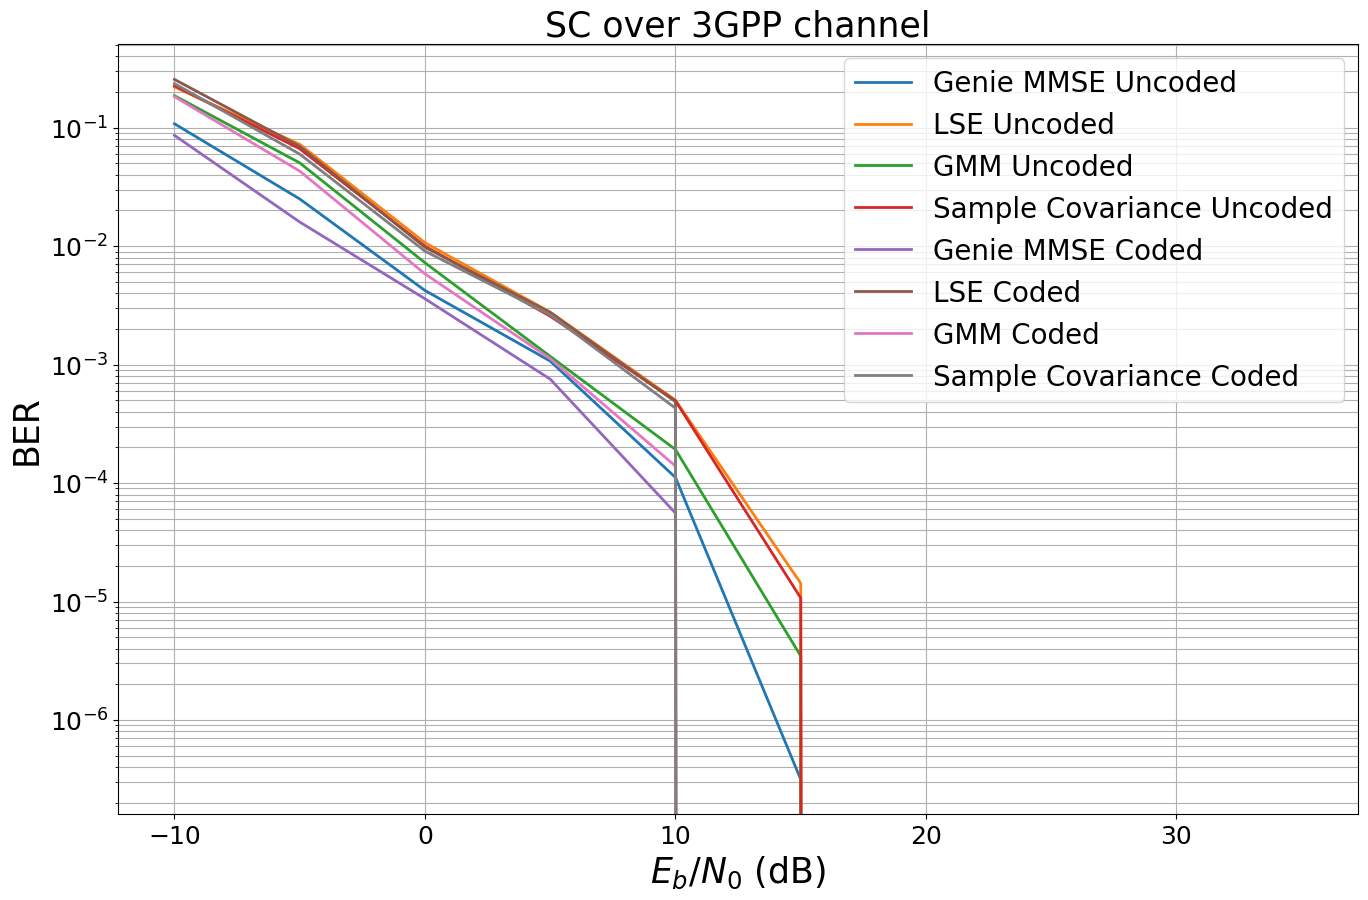

In [14]:
num_bits_per_symbol = 2
block_length = 256
ebno_db_min = -10.0 # Minimum value of Eb/N0 [dB] for simulations
ebno_db_max = 35.0 # Maximum value of Eb/N0 [dB] for simulations
batch_size = 500 # How many examples are processed by Sionna in parallel
n_coherence = 1
n_antennas = 32
training_batch_size = 10000
covariance_type = 'circulant'
n_gmm_components = 128
code_rate = 0.5
estimator = 'gmm'

ber_plots = sn.utils.PlotBER("SC over 3GPP channel")

uncoded_mmse_model = end2endModel(
    num_bits_per_symbol=num_bits_per_symbol, 
    block_length=block_length, 
    n_coherence=n_coherence, 
    n_antennas=n_antennas,
    training_batch_size=training_batch_size,
    covariance_type=covariance_type,
    n_gmm_components=n_gmm_components,
    estimator='mmse'
)
    
ber_plots.simulate(
    uncoded_mmse_model,
    ebno_dbs=np.linspace(ebno_db_min, ebno_db_max, 10),
    batch_size=batch_size,
    num_target_block_errors=100, # simulate until 100 block errors occured
    legend="Genie MMSE Uncoded",
    soft_estimates=True,
    max_mc_iter=100, # run 100 Monte-Carlo simulations (each with batch_size samples)
    show_fig=False   
)

uncoded_ls_model = end2endModel(
    num_bits_per_symbol=num_bits_per_symbol, 
    block_length=block_length, 
    n_coherence=n_coherence, 
    n_antennas=n_antennas, 
    training_batch_size=training_batch_size,
    covariance_type=covariance_type,
    n_gmm_components=n_gmm_components,
    estimator='ls'
)

ber_plots.simulate(
    uncoded_ls_model,
    ebno_dbs=np.linspace(ebno_db_min, ebno_db_max, 10),
    batch_size=batch_size,
    num_target_block_errors=100, # simulate until 100 block errors occured
    legend="LSE Uncoded",
    soft_estimates=True,
    max_mc_iter=100, # run 100 Monte-Carlo simulations (each with batch_size samples)
    show_fig=False
)

uncoded_gmm_model = end2endModel(
    num_bits_per_symbol=num_bits_per_symbol, 
    block_length=block_length, 
    n_coherence=n_coherence, 
    n_antennas=n_antennas,
    training_batch_size=training_batch_size,
    covariance_type=covariance_type,
    n_gmm_components=n_gmm_components,
    estimator='gmm'
)

ber_plots.simulate(
    uncoded_gmm_model,
    ebno_dbs=np.linspace(ebno_db_min, ebno_db_max, 10),
    batch_size=batch_size,
    num_target_block_errors=100, # simulate until 100 block errors occured
    legend="GMM Uncoded",
    soft_estimates=True,
    max_mc_iter=100, # run 100 Monte-Carlo simulations (each with batch_size samples)
    show_fig=False
)

uncoded_sample_cov_model = end2endModel(
    num_bits_per_symbol=num_bits_per_symbol, 
    block_length=block_length, 
    n_coherence=n_coherence, 
    n_antennas=n_antennas,
    training_batch_size=training_batch_size,
    covariance_type=covariance_type,
    n_gmm_components=1,
    estimator='gmm'
)

ber_plots.simulate(
    uncoded_sample_cov_model,
    ebno_dbs=np.linspace(ebno_db_min, ebno_db_max, 10),
    batch_size=batch_size,
    num_target_block_errors=100, # simulate until 100 block errors occured
    legend="Sample Covariance Uncoded",
    soft_estimates=True,
    max_mc_iter=100, # run 100 Monte-Carlo simulations (each with batch_size samples)
    show_fig=False
)

coded_mmse_model = end2endModel(
    num_bits_per_symbol=num_bits_per_symbol, 
    block_length=block_length, 
    n_coherence=n_coherence, 
    n_antennas=n_antennas,
    training_batch_size=training_batch_size,
    covariance_type=covariance_type,
    n_gmm_components=n_gmm_components,
    estimator='mmse',
    code_rate=code_rate
)

ber_plots.simulate(
    coded_mmse_model,
    ebno_dbs=np.linspace(ebno_db_min, ebno_db_max, 10),
    batch_size=batch_size,
    num_target_block_errors=100, # simulate until 100 block errors occured
    legend="Genie MMSE Coded",
    soft_estimates=True,
    max_mc_iter=100, # run 100 Monte-Carlo simulations (each with batch_size samples)
    show_fig=False
)

coded_ls_model = end2endModel(
    num_bits_per_symbol=num_bits_per_symbol, 
    block_length=block_length, 
    n_coherence=n_coherence, 
    n_antennas=n_antennas,
    training_batch_size=training_batch_size,
    covariance_type=covariance_type,
    n_gmm_components=n_gmm_components,
    estimator='ls',
    code_rate=code_rate
)

ber_plots.simulate(
    coded_ls_model,
    ebno_dbs=np.linspace(ebno_db_min, ebno_db_max, 10),
    batch_size=batch_size,
    num_target_block_errors=100, # simulate until 100 block errors occured
    legend="LSE Coded",
    soft_estimates=True,
    max_mc_iter=100, # run 100 Monte-Carlo simulations (each with batch_size samples)
    show_fig=False
)

coded_gmm_model = end2endModel(
    num_bits_per_symbol=num_bits_per_symbol, 
    block_length=block_length, 
    n_coherence=n_coherence, 
    n_antennas=n_antennas,
    training_batch_size=training_batch_size,
    covariance_type=covariance_type,
    n_gmm_components=n_gmm_components,
    estimator='gmm',
    code_rate=code_rate
)

ber_plots.simulate(
    coded_gmm_model,
    ebno_dbs=np.linspace(ebno_db_min, ebno_db_max, 10),
    batch_size=batch_size,
    num_target_block_errors=100, # simulate until 100 block errors occured
    legend="GMM Coded",
    soft_estimates=True,
    max_mc_iter=100, # run 100 Monte-Carlo simulations (each with batch_size samples)
    show_fig=False
)

coded_sample_cov_model = end2endModel(
    num_bits_per_symbol=num_bits_per_symbol, 
    block_length=block_length, 
    n_coherence=n_coherence, 
    n_antennas=n_antennas,
    training_batch_size=training_batch_size,
    covariance_type=covariance_type,
    n_gmm_components=1,
    estimator='gmm',
    code_rate=code_rate
)

ber_plots.simulate(
    coded_sample_cov_model,
    ebno_dbs=np.linspace(ebno_db_min, ebno_db_max, 10),
    batch_size=batch_size,
    num_target_block_errors=100, # simulate until 100 block errors occured
    legend="Sample Covariance Coded",
    soft_estimates=True,
    max_mc_iter=100, # run 100 Monte-Carlo simulations (each with batch_size samples)
    show_fig=False
)

ber_plots()